<hr style="border:2px solid black"></hr>

# Import Libraries

<hr style="border:2px solid black"></hr>

In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, LSTM, Conv1D, MaxPool1D, Input

pd.set_option('display.max_columns', None)  

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2024-07-30 10:02:57.366017: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 10:02:57.405837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 10:02:57.406412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-30 10:02:58.258535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<hr style="border:2px solid black"></hr>

# Data Preparation

<hr style="border:2px solid black"></hr>

<hr style="border:1px solid black"></hr>

## Read in the Master Data File

<hr style="border:1px solid black"></hr>

In [2]:
##----------------------------------------------------------------------------------------------------##
## Read in the Master Data File:                                                                      ##
##----------------------------------------------------------------------------------------------------##

data = pd.read_csv('./data/master_data.csv')

##----------------------------------------------------------------------------------------------------##
## Display Data Head and Info:                                                                        ##
##----------------------------------------------------------------------------------------------------##

display(data.head())

data.info()

,Date,Day,Month,Year,Traffic,Count,Gross Sales,cloudcover,conditions,dew,feelslike,feelslikemax,feelslikemin,humidity,moonphase,precip,precipcover,precipprob,preciptype,sealevelpressure,severerisk,snow,snowdepth,solarenergy,solarradiation,sunrise,sunset,temp,tempmax,tempmin,uvindex,visibility,windgust,windspeed
0,2023-03-01,Wednesday,March,2023,13,0.0,0.00,30.5,Partially cloudy,39.8,52.2,74.7,35.7,63.2,0.31,0.000,0.00,0,none,1007.0,10,0.0,0.0,6.7,77.3,07:17:58,18:36:33,53.8,74.7,38.7,3,9.9,28.9,16.6
1,2023-03-02,Thursday,March,2023,14,1.0,0.01,44.0,Partially cloudy,33.3,40.1,51.5,27.0,66.3,0.34,0.000,0.00,0,none,1012.1,10,0.0,0.0,6.6,78.0,07:16:29,18:37:39,44.3,51.5,34.4,3,9.9,17.2,12.2
2,2023-03-03,Friday,March,2023,6,0.0,0.00,91.3,"Snow, Rain, Overcast",36.3,32.0,37.2,21.7,84.5,0.37,2.278,66.67,100,"rain,snow",997.0,10,0.0,0.0,0.8,8.8,07:14:59,18:38:44,40.7,43.1,35.0,0,6.4,43.6,30.1
3,2023-03-04,Saturday,March,2023,12,0.0,0.00,34.6,Partially cloudy,31.7,37.7,53.8,23.8,71.1,0.41,0.000,0.00,0,none,1014.3,10,0.0,0.0,7.9,88.5,07:13:28,18:39:49,41.4,53.8,29.9,4,8.7,34.2,18.1
4,2023-03-05,Sunday,March,2023,14,0.0,0.00,36.6,Partially cloudy,34.2,44.6,56.3,32.3,64.4,0.44,0.000,0.00,0,none,1022.3,10,0.0,0.0,6.8,80.7,07:11:57,18:40:53,46.6,56.3,35.8,3,9.3,19.5,13.3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              406 non-null    object 
 1   Day               406 non-null    object 
 2   Month             406 non-null    object 
 3   Year              406 non-null    int64  
 4   Traffic           406 non-null    int64  
 5   Count             406 non-null    float64
 6   Gross Sales       406 non-null    float64
 7   cloudcover        406 non-null    float64
 8   conditions        406 non-null    object 
 9   dew               406 non-null    float64
 10  feelslike         406 non-null    float64
 11  feelslikemax      406 non-null    float64
 12  feelslikemin      406 non-null    float64
 13  humidity          406 non-null    float64
 14  moonphase         406 non-null    float64
 15  precip            406 non-null    float64
 16  precipcover       406 non-null    float64
 1

<hr style="border:1px solid black"></hr>

## Convert Sunrise and Sunset to Seconds From Midnight

<hr style="border:1px solid black"></hr>

In [3]:
##----------------------------------------------------------------------------------------------------##
## Split the Time into Hours, Minutes, and Seconds:                                                   ##
##----------------------------------------------------------------------------------------------------##

sunrise = data["sunrise"]
sunset  = data["sunset"]

sunrise_split = sunrise.str.split(':')
sunset_split  = sunset.str.split(':')

##----------------------------------------------------------------------------------------------------##
## Convert the Hour and Minutes into Seconds:                                                         ##
##----------------------------------------------------------------------------------------------------##

sunrise_hour   = [int(row[0]) * 3600 for row in sunrise_split]
sunrise_minute = [int(row[1]) * 60   for row in sunrise_split]
sunrise_second = [int(row[2])        for row in sunrise_split]

sunset_hour   = [int(row[0]) * 3600 for row in sunset_split]
sunset_minute = [int(row[1]) * 60   for row in sunset_split]
sunset_second = [int(row[2])        for row in sunset_split]

##----------------------------------------------------------------------------------------------------##
## Sum the Values to get Seconds from Midnight:                                                       ##
##----------------------------------------------------------------------------------------------------##

sunrise_df = pd.DataFrame({'hour' : sunrise_hour, 'minute' : sunrise_minute, 'second' : sunrise_second})
sunset_df  = pd.DataFrame({'hour' : sunset_hour,  'minute' : sunset_minute,  'second' : sunset_second})

data["sunrise"] = sunrise_df["hour"] + sunrise_df["minute"] + sunrise_df["second"]
data["sunset"]  = sunset_df["hour"]  + sunset_df["minute"]  + sunset_df["second"]

<hr style="border:1px solid black"></hr>

## Design a Column Transformer

<hr style="border:1px solid black"></hr>

In [4]:
##----------------------------------------------------------------------------------------------------##
## Create the DataType selector:                                                                      ##
##----------------------------------------------------------------------------------------------------##

selector = make_column_selector(dtype_include = 'object')

##----------------------------------------------------------------------------------------------------##
## Create the transformer pipelines:                                                                  ##
##----------------------------------------------------------------------------------------------------##

categorical_transformer = Pipeline([
    
    ('onehot',   OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))
])

numerical_transformer = Pipeline([
    
    ('scaler', StandardScaler())
])

##----------------------------------------------------------------------------------------------------##
## Create the column transformer:                                                                     ##
##----------------------------------------------------------------------------------------------------##

transformer = make_column_transformer(
    
    (categorical_transformer, selector), 
    remainder = numerical_transformer
)

<hr style="border:1px solid black"></hr>

## Identify Testing and Training Data

<hr style="border:1px solid black"></hr>

In [5]:
##----------------------------------------------------------------------------------------------------##
## Select Data Features:                                                                              ##
##----------------------------------------------------------------------------------------------------##

#features = data.drop(["Date", "Traffic", "Count", "Gross Sales"], axis = 1)

features = data[["Day", "sunrise", "sunset", "tempmax", "tempmin", "precipprob", "humidity"]]

##----------------------------------------------------------------------------------------------------##
## Select Data Target:                                                                                ##
##----------------------------------------------------------------------------------------------------##

target = data["Traffic"]

target = pd.Series([a if a < 100 else 10 for a in target])

##----------------------------------------------------------------------------------------------------##
## Transform the Data Features:                                                                       ##
##----------------------------------------------------------------------------------------------------##

features_transformed = transformer.fit_transform(features)

feature_names = transformer.get_feature_names_out()

feature_names = [s.replace('pipeline__',  '') for s in feature_names]
feature_names = [s.replace('remainder__', '') for s in feature_names]

features_df = pd.DataFrame(features_transformed, columns = feature_names)

<hr style="border:2px solid black"></hr>

# Prepare the Models

<hr style="border:2px solid black"></hr>

<hr style="border:1px solid black"></hr>

## Model 1 (Square Shape)

<hr style="border:1px solid black"></hr>

In [6]:
##----------------------------------------------------------------------------------------------------##
## Define the Neural Network Model:                                                                   ##
##----------------------------------------------------------------------------------------------------##

def model_type_1(data):

    ##------------------------------------------------------------------------------------------------##
    ## Create the input layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    input = Input(data.shape[1], name = "input")   

    ##------------------------------------------------------------------------------------------------##
    ## Create a flatten layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    flatten = Flatten(name = "flatten")(input)

    ##------------------------------------------------------------------------------------------------##
    ## Create the hidden layers:                                                                      ##
    ##------------------------------------------------------------------------------------------------##

    dense_1 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_1")(flatten)

    dense_2 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_2")(dense_1)

    dense_3 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_3")(dense_2)

    dense_4 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_4")(dense_3)

    dense_5 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_5")(dense_4)

    ##------------------------------------------------------------------------------------------------##
    ## Create the output layer:                                                                       ##
    ##------------------------------------------------------------------------------------------------##

    output = Dense(1, name = "output")(dense_5)

    ##------------------------------------------------------------------------------------------------##
    ## Create the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    model = Model(inputs = input, outputs = output, name = "square-model")

    ##------------------------------------------------------------------------------------------------##
    ## Compile the model:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

    ##------------------------------------------------------------------------------------------------##
    ## Print a model summary:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    print()
    model.summary()

    ##------------------------------------------------------------------------------------------------##
    ## Return the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    return model

<hr style="border:1px solid black"></hr>

## Model 2 (Pyramid Shape)

<hr style="border:1px solid black"></hr>

In [7]:
##----------------------------------------------------------------------------------------------------##
## Define the Neural Network Model:                                                                   ##
##----------------------------------------------------------------------------------------------------##

def model_type_2(data):

    ##------------------------------------------------------------------------------------------------##
    ## Create the input layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    input = Input(data.shape[1], name = "input")   

    ##------------------------------------------------------------------------------------------------##
    ## Create a flatten layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    flatten = Flatten(name = "flatten")(input)

    ##------------------------------------------------------------------------------------------------##
    ## Create the hidden layers:                                                                      ##
    ##------------------------------------------------------------------------------------------------##
    
    dense_1 = Dense(800, activation = "relu", kernel_initializer = "normal", name = "dense_1")(flatten)

    dense_2 = Dense(400, activation = "relu", kernel_initializer = "normal", name = "dense_2")(dense_1)

    dense_3 = Dense(200, activation = "relu", kernel_initializer = "normal", name = "dense_3")(dense_2)

    dense_4 = Dense(100, activation = "relu", kernel_initializer = "normal", name = "dense_4")(dense_3)

    dense_5 = Dense(50,  activation = "relu", kernel_initializer = "normal", name = "dense_5")(dense_4)

    ##------------------------------------------------------------------------------------------------##
    ## Create the output layer:                                                                       ##
    ##------------------------------------------------------------------------------------------------##

    output = Dense(1, name = "output")(dense_5)

    ##------------------------------------------------------------------------------------------------##
    ## Create the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    model = Model(inputs = input, outputs = output, name = "pyramid-model")

    ##------------------------------------------------------------------------------------------------##
    ## Compile the model:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

    ##------------------------------------------------------------------------------------------------##
    ## Print a model summary:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    print()
    model.summary()

    ##------------------------------------------------------------------------------------------------##
    ## Return the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    return model

<hr style="border:1px solid black"></hr>

## Model 3 (Inverse Pyramid Shape)

<hr style="border:1px solid black"></hr>

In [8]:
##----------------------------------------------------------------------------------------------------##
## Define the Neural Network Model:                                                                   ##
##----------------------------------------------------------------------------------------------------##

def model_type_3(data):

    ##------------------------------------------------------------------------------------------------##
    ## Create the input layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    input = Input(data.shape[1], name = "input")   

    ##------------------------------------------------------------------------------------------------##
    ## Create a flatten layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    flatten = Flatten(name = "flatten")(input)

    ##------------------------------------------------------------------------------------------------##
    ## Create the hidden layers:                                                                      ##
    ##------------------------------------------------------------------------------------------------##

    dense_1 = Dense(50,  activation = "relu", name = "dense_1")(flatten)

    dense_2 = Dense(100, activation = "relu", name = "dense_2")(dense_1)

    dense_3 = Dense(200, activation = "relu", name = "dense_3")(dense_2)

    dense_4 = Dense(400, activation = "relu", name = "dense_4")(dense_3)

    dense_5 = Dense(800, activation = "relu", name = "dense_5")(dense_4)

    ##------------------------------------------------------------------------------------------------##
    ## Create the output layer:                                                                       ##
    ##------------------------------------------------------------------------------------------------##

    output = Dense(1, name = "output")(dense_5)

    ##------------------------------------------------------------------------------------------------##
    ## Create the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    model = Model(inputs = input, outputs = output, name = "inverse-pyramid-model")

    ##------------------------------------------------------------------------------------------------##
    ## Compile the model:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

    ##------------------------------------------------------------------------------------------------##
    ## Print a model summary:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    print()
    model.summary()

    ##------------------------------------------------------------------------------------------------##
    ## Return the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    return model

<hr style="border:1px solid black"></hr>

## Model 4 (Diamond Shape)

<hr style="border:1px solid black"></hr>

In [9]:
##----------------------------------------------------------------------------------------------------##
## Define the Neural Network Model:                                                                   ##
##----------------------------------------------------------------------------------------------------##

def model_type_4(data):

    ##------------------------------------------------------------------------------------------------##
    ## Create the input layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    input = Input(data.shape[1], name = "input")   

    ##------------------------------------------------------------------------------------------------##
    ## Create a flatten layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    flatten = Flatten(name = "flatten")(input)

    ##------------------------------------------------------------------------------------------------##
    ## Create the hidden layers:                                                                      ##
    ##------------------------------------------------------------------------------------------------##

    dense_1 = Dense(50,  activation = "relu", name = "dense_1")(flatten)

    dense_2 = Dense(100, activation = "relu", name = "dense_2")(dense_1)

    dense_3 = Dense(200, activation = "relu", name = "dense_3")(dense_2)

    dense_4 = Dense(400, activation = "relu", name = "dense_4")(dense_3)

    dense_5 = Dense(200, activation = "relu", name = "dnese_5")(dense_4)

    dense_6 = Dense(100, activation = "relu", name = "dense_6")(dense_5)

    dense_7 = Dense(50,  activation = "relu", name = "dense_7")(dense_6)

    ##------------------------------------------------------------------------------------------------##
    ## Create the output layer:                                                                       ##
    ##------------------------------------------------------------------------------------------------##

    output = Dense(1, name = "output")(dense_7)

    ##------------------------------------------------------------------------------------------------##
    ## Create the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    model = Model(inputs = input, outputs = output, name = "diamond-model")

    ##------------------------------------------------------------------------------------------------##
    ## Compile the model:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

    ##------------------------------------------------------------------------------------------------##
    ## Print a model summary:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    print()
    model.summary()

    ##------------------------------------------------------------------------------------------------##
    ## Return the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    return model

<hr style="border:1px solid black"></hr>

## Model 5 (Convolutional Model)

<hr style="border:1px solid black"></hr>

In [10]:
##----------------------------------------------------------------------------------------------------##
## Define the Neural Network Model:                                                                   ##
##----------------------------------------------------------------------------------------------------##

def model_type_5(data):

    ##------------------------------------------------------------------------------------------------##
    ## Create the input layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    input  = Input((data.shape[1],1), name = "input")

    ##------------------------------------------------------------------------------------------------##
    ## Create convolution layers:                                                                     ##
    ##------------------------------------------------------------------------------------------------##

    conv_1 = Conv1D(50, 2, dilation_rate = 2, padding = "same", activation = "relu", 
                    name = "conv_1")(input)

    conv_2 = Conv1D(100, 2, dilation_rate = 2, padding = "same", activation = "relu",
                    name = "conv_2")(conv_1)

    conv_3 = Conv1D(50, 2, dilation_rate = 2, padding = "same", activation = "relu",
                    name = "conv_3")(conv_2)

    ##------------------------------------------------------------------------------------------------##
    ## Create a flatten layer:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    flatten = Flatten(name = "flatten")(conv_3)

    ##------------------------------------------------------------------------------------------------##
    ## Create the hidden layers:                                                                      ##
    ##------------------------------------------------------------------------------------------------##

    dense_1 = Dense(50,  activation = "relu", name = "dense_1")(flatten)

    dense_2 = Dense(100,  activation = "relu", name = "dense_2")(dense_1)

    dense_3 = Dense(50,  activation = "relu", name = "dense_3")(dense_2)

    ##------------------------------------------------------------------------------------------------##
    ## Create the output layer:                                                                       ##
    ##------------------------------------------------------------------------------------------------##

    output = Dense(1, name = "output")(dense_3)

    ##------------------------------------------------------------------------------------------------##
    ## Create the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    model = Model(inputs = input, outputs = output, name = "convolutional-model")

    ##------------------------------------------------------------------------------------------------##
    ## Compile the model:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    model.compile(optimizer = "adam", loss = "mse", metrics = ["mae"])

    ##------------------------------------------------------------------------------------------------##
    ## Print a model summary:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    print()
    model.summary()

    ##------------------------------------------------------------------------------------------------##
    ## Return the model:                                                                              ##
    ##------------------------------------------------------------------------------------------------##

    return model

<hr style="border:2px solid black"></hr>

# Evaluate the Models

<hr style="border:2px solid black"></hr>

<hr style="border:1px solid black"></hr>

## Create a Function to Evalute the Models

<hr style="border:1px solid black"></hr>

In [11]:
##====================================================================================================##
## Function:    evaluate_model                                                                        ##
##                                                                                                    ##
## DESCRIPTION: This function is used to evaluate a neural network model.                             ##
##                                                                                                    ##
## INPUT(S):    1) X:             Feature data                                                        ##
##              2) y:             Target data                                                         ##
##              3) tranformer:    Data column transformer                                             ##
##              4) selectors:     List of models used during feature selection                        ##
##              5) regressors:    List of models used during regression                               ##
##              6) score_method:  Method used to generate model scores                                ##
##              7) n_runs:        Number of cross-validation re-runs                                  ##
##              8) plot:          Boolean value, if true a plot of the importances is made            ##
##                                                                                                    ##
## OUTPUT(S):   1) X_return:      Streamlined feature data                                            ##
##              2) importance_df: Category importance data                                            ##
##====================================================================================================##

def evaluate_model(model_type, features, target):

    ##------------------------------------------------------------------------------------------------##
    ## Set the parameters for the evaluation:                                                         ##
    ##------------------------------------------------------------------------------------------------##

    epochs = 200

    batch_size = 8

    verbose = 0

    n_splits = 2

    ##------------------------------------------------------------------------------------------------##
    ## Split the features and target into training and testing data sets:                             ##
    ##------------------------------------------------------------------------------------------------##

    X_train, X_test, y_train, y_test = train_test_split(features, target)
    
    ##------------------------------------------------------------------------------------------------##
    ## Instantiate the model:                                                                         ##
    ##------------------------------------------------------------------------------------------------##

    model = model_type(X_train)

    ##------------------------------------------------------------------------------------------------##
    ## Fit the model:                                                                                 ##
    ##------------------------------------------------------------------------------------------------##

    ti = time.time()

    history = model.fit(X_train, y_train, 
                        epochs            = epochs, 
                        batch_size        = batch_size,
                        verbose           = verbose,
                        validation_data   = (X_test, y_test),
                        shuffle           = True
                       )

    tf = time.time()

    ##------------------------------------------------------------------------------------------------##
    ## Get the mean absolute error through k-fold cross-validation:                                   ##
    ##------------------------------------------------------------------------------------------------##

    estimator = KerasRegressor(model      = model, 
                               epochs     = epochs, 
                               batch_size = batch_size, 
                               verbose    = verbose)

    kfold = KFold(n_splits = n_splits)

    results = cross_val_score(estimator, features, target, cv = kfold, 
                              scoring = 'neg_mean_absolute_error')

    ##------------------------------------------------------------------------------------------------##
    ## Report the mean absolute error on testing data:                                                ##
    ##------------------------------------------------------------------------------------------------##

    print()

    mae = np.abs(results.mean())

    print("Mean Absolute Error: " + str(np.round(np.abs(results.mean()), 3)) + " +/- " + 
          str(np.round(results.std(), 3)))
    print("Fit Time: " + str(np.round(tf - ti, 3)) + " seconds\n")

    return model, history, mae

<hr style="border:1px solid black"></hr>

## Evaluate Each Model

<hr style="border:1px solid black"></hr>

In [12]:
##----------------------------------------------------------------------------------------------------##
## Create lists to store outputs from model evaluations:                                              ##
##----------------------------------------------------------------------------------------------------##

model_list   = []
history_list = []
error_list   = []

##----------------------------------------------------------------------------------------------------##
## Choose the types of models to be evaluated:                                                        ##
##----------------------------------------------------------------------------------------------------##

evaluation_list = [model_type_1, model_type_2, model_type_3, model_type_4, model_type_5]

##----------------------------------------------------------------------------------------------------##
## Evaluate the chosen models:                                                                        ##
##----------------------------------------------------------------------------------------------------##

counter = 1

for item in evaluation_list:

    print("Model Number " + str(counter) + '\n')

    model, history, error = evaluate_model(item, features_df, target)

    ##------------------------------------------------------------------------------------------------##
    ## Store the results in lists:                                                                    ##
    ##------------------------------------------------------------------------------------------------##

    model_list.append(model)

    history_list.append(history)

    error_list.append(error)

    counter += 1

Model Number 1


Model: "square-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 400)               5200      
                                                                 
 dense_2 (Dense)             (None, 400)               160400    
                                                                 
 dense_3 (Dense)             (None, 400)               160400    
                                                                 
 dense_4 (Dense)             (None, 400)               160400    
                                                                 
 dense_5 (Dense)             (None, 4

2024-07-30 10:04:30.090678: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0026eb7b407847b295d8a5ed97ded135: INVALID_ARGUMENT: ram://0026eb7b407847b295d8a5ed97ded135 is a directory.
2024-07-30 10:05:10.269286: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://05a27e2fdcb34e6fa528c54e18724a00: INVALID_ARGUMENT: ram://05a27e2fdcb34e6fa528c54e18724a00 is a directory.



Mean Absolute Error: 3.355 +/- 0.094
Fit Time: 60.833 seconds

Model Number 2


Model: "pyramid-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 800)               10400     
                                                                 
 dense_2 (Dense)             (None, 400)               320400    
                                                                 
 dense_3 (Dense)             (None, 200)               80200     
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                      

2024-07-30 10:06:45.567957: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://43e48c1a87ad47598eb22bf604c7312d: INVALID_ARGUMENT: ram://43e48c1a87ad47598eb22bf604c7312d is a directory.
2024-07-30 10:07:15.985682: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ef43c142b9814f7dbe1d47d3dae909b3: INVALID_ARGUMENT: ram://ef43c142b9814f7dbe1d47d3dae909b3 is a directory.



Mean Absolute Error: 3.302 +/- 0.224
Fit Time: 49.949 seconds

Model Number 3


Model: "inverse-pyramid-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                650       
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dense_4 (Dense)             (None, 400)               80400     
                              

2024-07-30 10:08:38.926543: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://55a6bb04b8fb41a98365ce1ef1630379: INVALID_ARGUMENT: ram://55a6bb04b8fb41a98365ce1ef1630379 is a directory.
2024-07-30 10:09:10.715248: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://ae70e637b0f34f669faf305588600442: INVALID_ARGUMENT: ram://ae70e637b0f34f669faf305588600442 is a directory.



Mean Absolute Error: 2.955 +/- 0.139
Fit Time: 52.562 seconds

Model Number 4


Model: "diamond-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                650       
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
 dense_4 (Dense)             (None, 400)               80400     
                                      

2024-07-30 10:10:20.291217: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://0714f84c606343b8a7ec9f93ee3f573c: INVALID_ARGUMENT: ram://0714f84c606343b8a7ec9f93ee3f573c is a directory.
2024-07-30 10:10:34.715023: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://9e5be16dd05842f4a3f0e2b6796c7ece: INVALID_ARGUMENT: ram://9e5be16dd05842f4a3f0e2b6796c7ece is a directory.



Mean Absolute Error: 3.511 +/- 0.109
Fit Time: 32.603 seconds

Model Number 5


Model: "convolutional-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12, 1)]           0         
                                                                 
 conv_1 (Conv1D)             (None, 12, 50)            150       
                                                                 
 conv_2 (Conv1D)             (None, 12, 100)           10100     
                                                                 
 conv_3 (Conv1D)             (None, 12, 50)            10050     
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                30050     
                                

2024-07-30 10:11:11.031447: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://d26576f78ba949acb2d905ee0f5fc03b: INVALID_ARGUMENT: ram://d26576f78ba949acb2d905ee0f5fc03b is a directory.
2024-07-30 10:11:23.333683: W tensorflow/core/util/tensor_slice_reader.cc:97] Could not open ram://f361e716f1da47348869587fe8e0fe29: INVALID_ARGUMENT: ram://f361e716f1da47348869587fe8e0fe29 is a directory.



Mean Absolute Error: 3.369 +/- 0.746
Fit Time: 21.161 seconds



<hr style="border:1px solid black"></hr>

## Get the Models' Predictions

<hr style="border:1px solid black"></hr>

In [13]:
##----------------------------------------------------------------------------------------------------##
## Create lists for predictions and errors :                                                          ##
##----------------------------------------------------------------------------------------------------##

predictions_list       = []
root_mean_squared_list = []
mean_absolute_list     = []

##----------------------------------------------------------------------------------------------------##
## Populate the predictions_list:                                                                     ##
##----------------------------------------------------------------------------------------------------##

for item in model_list:

    predictions_list.append(item.predict(features_df).T[0])

##----------------------------------------------------------------------------------------------------##
## Compute the prediction weights:                                                                    ##
##----------------------------------------------------------------------------------------------------##

error_list /= np.mean(error_list)

weights = 1 / error_list

weights_sum = np.sum(weights)

##----------------------------------------------------------------------------------------------------##
## Compute the weighted average prediction:                                                           ##
##----------------------------------------------------------------------------------------------------##

predictions_vote = []

for i in range(len(predictions_list[0])):

    predictions_vote.append(0)

    for j in range(len(predictions_list)):

        predictions_vote

    predictions_vote[-1] /= weights

predictions_ave = np.mean(predictions_list, axis = 0)

predictions_list.append(predictions_ave)

##----------------------------------------------------------------------------------------------------##
## Compute the RMSE for the models' predictions on the whole data set:                                ##
##----------------------------------------------------------------------------------------------------##

for item in predictions_list:

    root_mean_squared_list.append(np.sqrt(mean_squared_error(np.round(item).astype(int), target)))

##----------------------------------------------------------------------------------------------------##
## Compute the MAE for the models' predictions on the whole data set:                                 ##
##----------------------------------------------------------------------------------------------------##

for item in predictions_list:

    mean_absolute_list.append(mean_absolute_error(np.round(item).astype(int), target))

##----------------------------------------------------------------------------------------------------##
## Create a DataFrame containing the error results:                                                   ##
##----------------------------------------------------------------------------------------------------##

model_names = []

for i in range(len(predictions_list) - 1):

    model_names.append("model_" + str(i + 1))

model_names.append("average")

error_df = pd.DataFrame({
    
    "Models" : model_names,
    "RMSE"   : root_mean_squared_list,
    "MAE"    : mean_absolute_list
})

##----------------------------------------------------------------------------------------------------##
## Display the errors DataFrame:                                                                      ##
##----------------------------------------------------------------------------------------------------##

print()
print("Errors")
display(error_df)
print()

##----------------------------------------------------------------------------------------------------##
## Create a DataFrame containing the models' predictions:                                             ##
##----------------------------------------------------------------------------------------------------##

results_df = pd.DataFrame({"Date" : data["Date"]})

for i in range(len(predictions_list) - 1):

    results_df[model_names[i]] = np.round(predictions_list[i]).astype(int)

results_df["Average Predictions"] = np.round(predictions_list[-1]).astype(int)

results_df["Actual Values"] = np.round(target).astype(int)

print("Predictions")

results_df.sample(20)

13/13 [==============================] - 0s 3ms/step

Errors


,Models,RMSE,MAE
0,model_1,3.225514,1.536946
1,model_2,3.069394,1.312808
2,model_3,2.863908,1.369458
3,model_4,3.450923,1.258621
4,model_5,2.944896,1.440887
5,average,1.980819,1.125616



Predictions


,Date,model_1,model_2,model_3,model_4,model_5,Average Predictions,Actual Values
180,2023-08-28,1,3,3,3,2,2,3
335,2024-01-30,9,8,7,8,8,8,8
31,2023-04-01,13,9,9,13,25,14,10
374,2024-03-09,15,25,23,27,26,23,26
34,2023-04-04,1,1,1,1,6,2,1
183,2023-08-31,6,4,7,4,6,5,7
165,2023-08-13,4,4,4,4,4,4,4
69,2023-05-09,8,4,6,3,4,5,3
65,2023-05-05,8,12,10,8,11,10,11
341,2024-02-05,0,0,0,0,0,0,0


<hr style="border:1px solid black"></hr>

## Plot the Fitting History

<hr style="border:1px solid black"></hr>

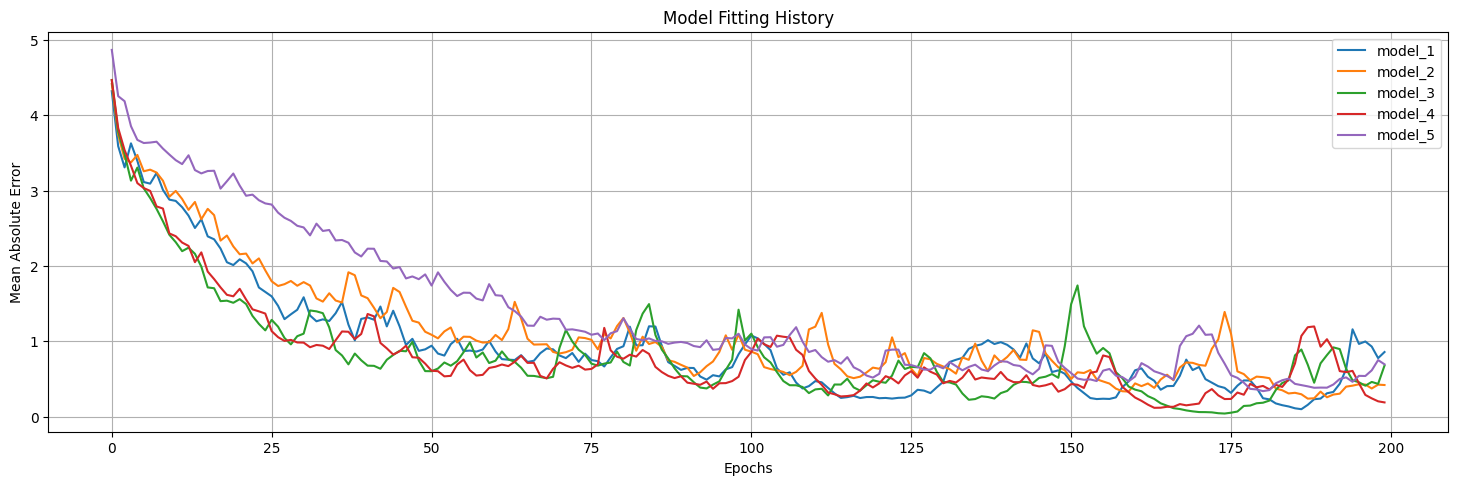

In [14]:
##----------------------------------------------------------------------------------------------------##
## Create the figure:                                                                                 ##
##----------------------------------------------------------------------------------------------------##

fig = plt.figure(figsize = (14, 8))

##----------------------------------------------------------------------------------------------------##
## Add a graph to the figure:                                                                         ##
##----------------------------------------------------------------------------------------------------##

graph_1 = fig.add_axes([ 0.0,  0.0, 1, 0.5])

##----------------------------------------------------------------------------------------------------##
## Add the fitting data to the graph:                                                                 ##
##----------------------------------------------------------------------------------------------------##

for i in range(len(history_list)):

    graph_1.plot(history_list[i].history['mae'], label = model_names[i])

##----------------------------------------------------------------------------------------------------##
## Set the graph's attributes:                                                                        ##
##----------------------------------------------------------------------------------------------------##

graph_1.set_title('Model Fitting History')

graph_1.set_ylabel('Mean Absolute Error')

graph_1.set_xlabel('Epochs')

graph_1.legend()

graph_1.grid()

<hr style="border:1px solid black"></hr>

## Plot the Prediction Error

<hr style="border:1px solid black"></hr>

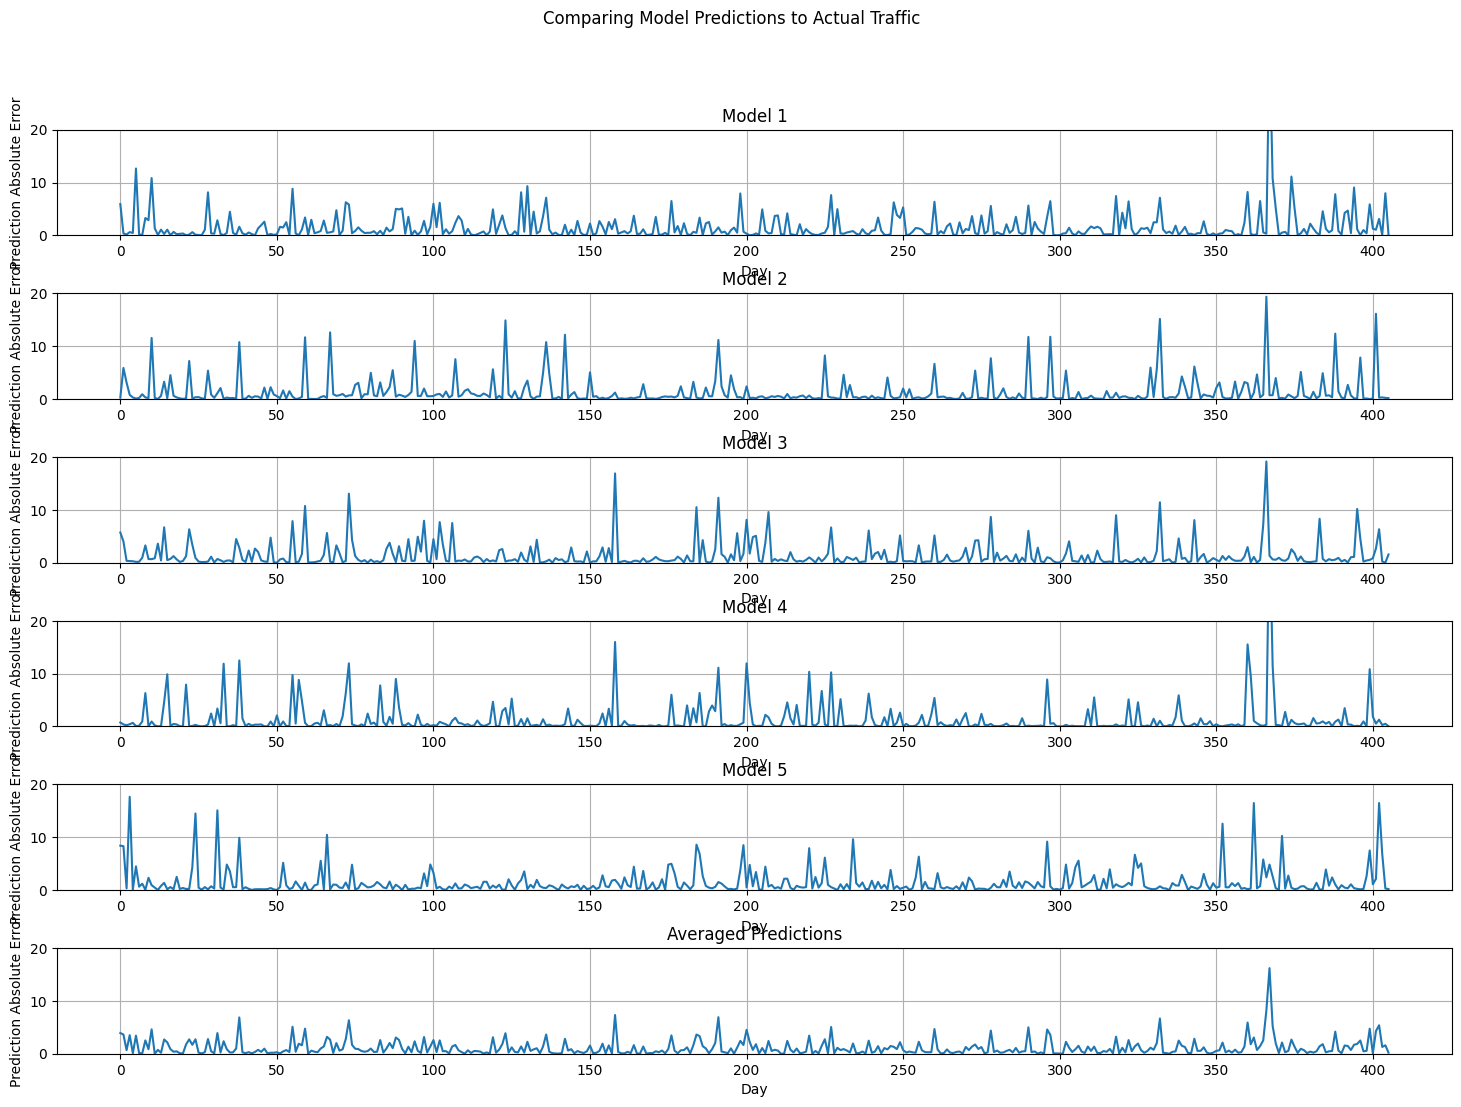

In [15]:
##----------------------------------------------------------------------------------------------------##
## Create the figure:                                                                                 ##
##----------------------------------------------------------------------------------------------------##

fig = plt.figure(figsize = (18, 12))

fig.suptitle('Comparing Model Predictions to Actual Traffic')

##----------------------------------------------------------------------------------------------------##
## Add graphs to the figure:                                                                          ##
##----------------------------------------------------------------------------------------------------##

graph_list = []

grid = fig.add_gridspec(len(predictions_list), hspace = 0.55)

graphs = grid.subplots() # fig.subplots(len(predictions_list), width_ratios = [1])

for i in range(len(predictions_list)):

    ##------------------------------------------------------------------------------------------------##
    ## Add data to the graphs:                                                                        ##
    ##------------------------------------------------------------------------------------------------##

    graphs[i].plot(np.abs(predictions_list[i] - target))

    ##------------------------------------------------------------------------------------------------##
    ## Set the graph titles:                                                                          ##
    ##------------------------------------------------------------------------------------------------##

    if (i != len(predictions_list) - 1): graphs[i].set_title('Model ' + str(i + 1))

    else: graphs[i].set_title('Averaged Predictions')

    ##------------------------------------------------------------------------------------------------##
    ## Set the graph axis labels:                                                                     ##
    ##------------------------------------------------------------------------------------------------##

    graphs[i].set_xlabel('Day')
    
    graphs[i].set_ylabel('Prediction Absolute Error')

    ##------------------------------------------------------------------------------------------------##
    ## Set window limits:                                                                             ##
    ##------------------------------------------------------------------------------------------------##

    graphs[i].set_ylim([0, 20])
    
    ##------------------------------------------------------------------------------------------------##
    ## Create grids:                                                                                  ##
    ##------------------------------------------------------------------------------------------------##

    graphs[i].grid()